In [ ]:
# Run this cell, if you are running the notebook on Google Colab:
!git clone https://github.com/CRC183-summer-school/school_2021.git

In [44]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(sys.path[0] + "./school_2021/notebooks/")
from IsingData import generate_Ising_configurations

# Zipping the Ising model

<h2 style="color:red"> !! The cell below takes ~15 minutes to run locally on a 2019 MacBook Pro </h2>

Try decreasing the number of samples from 1000 -> 100 to get a quick idea

In [45]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.6, 3.0, 0.1) #np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = {}
for L in [10, 20, 40]:#, 80]:
    all_data[L] = generate_Ising_configurations(L, 1000, Ts) # Returns half the number of samples asked for

Generating samples for L = 10 at T = 1.600
Generating samples for L = 10 at T = 1.700
Generating samples for L = 10 at T = 1.800
Generating samples for L = 10 at T = 1.900
Generating samples for L = 10 at T = 2.000
Generating samples for L = 10 at T = 2.100
Generating samples for L = 10 at T = 2.200
Generating samples for L = 10 at T = 2.300
Generating samples for L = 10 at T = 2.400
Generating samples for L = 10 at T = 2.500
Generating samples for L = 10 at T = 2.600
Generating samples for L = 10 at T = 2.700
Generating samples for L = 10 at T = 2.800
Generating samples for L = 10 at T = 2.900
Generating samples for L = 20 at T = 1.600
Generating samples for L = 20 at T = 1.700
Generating samples for L = 20 at T = 1.800
Generating samples for L = 20 at T = 1.900
Generating samples for L = 20 at T = 2.000
Generating samples for L = 20 at T = 2.100
Generating samples for L = 20 at T = 2.200
Generating samples for L = 20 at T = 2.300
Generating samples for L = 20 at T = 2.400
Generating 

In [46]:
import gzip
import shutil

sizes = {}
Ts = np.arange(1.6, 3.0, 0.1)
for L in [10, 20, 40]:#, 80]:
    sizes[L] = []

    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        out = gzip.compress(data)
        sizes[L].append(out.__sizeof__())

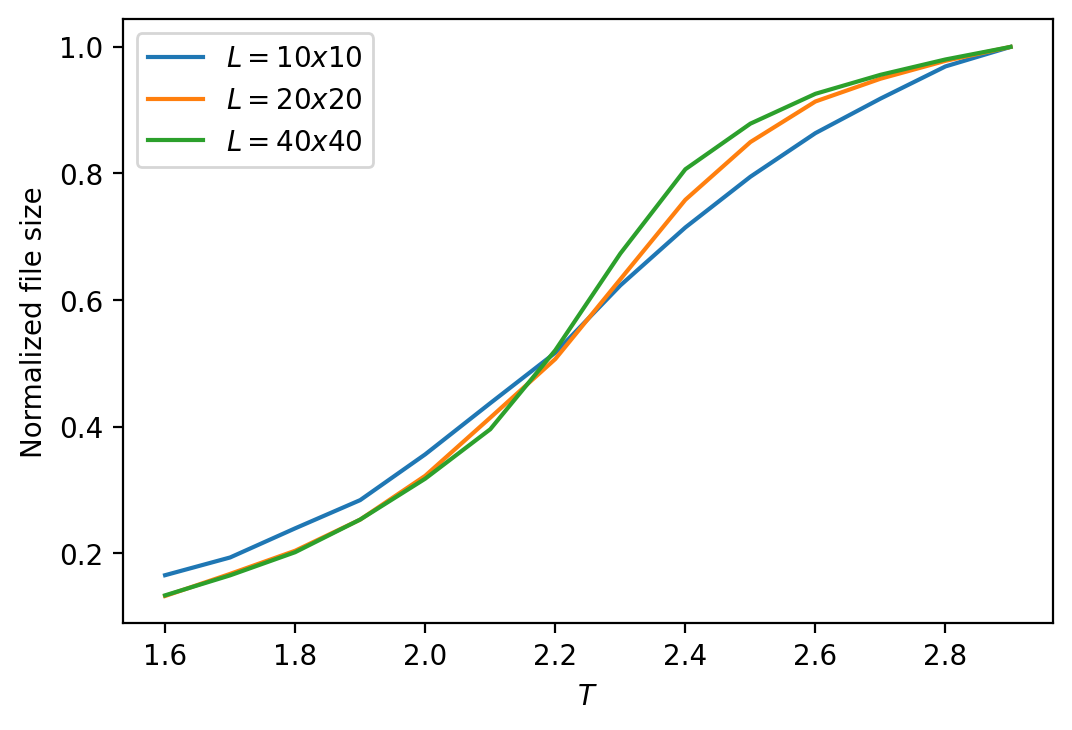

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)
for L in [10, 20, 40]:#, 80]:
    ax.plot(Ts, sizes[L]/np.max(sizes[L]), label='$L=%dx%d$'%(L,L))
    
ax.set_xlabel("$T$")
ax.set_ylabel("Normalized file size")
ax.legend(fancybox=True)

## Challenge idea

Add system size 80, more samples, and try a scaling collapse to extract T_c

# PCA'ing the Ising model

Be sure to also check out https://arxiv.org/abs/1606.00318

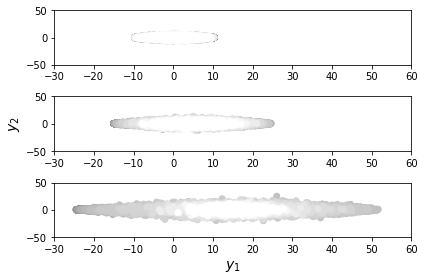

In [48]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(3,1)
Ts = np.arange(1.6, 3.0, 0.1)
principal_vectors = [] 
for a,L in enumerate([10,20,40]):
    raw_x = []
    colors = [] 
   
    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        for c,snapshot in enumerate(data):
            raw_x.append( snapshot )
            colors.append( np.array([1, 1, 1]) * T/np.max(Ts) ) 

    pca = PCA(n_components=2)
    pca.fit(raw_x)
    proj = pca.transform(raw_x)
    principal_vectors.append( pca.components_[0] )
    ax[a].scatter(proj[:,0], proj[:,1], color=colors)
    
    ax[a].set_xlim([-30,60])
    ax[a].set_ylim([-50,50])
    
ax[1].set_ylabel("$y_2$", fontsize=14)
ax[2].set_xlabel("$y_1$", fontsize=14)
fig.tight_layout()

Text(0, 0.5, 'First principal component vector')

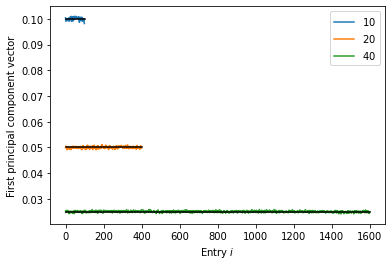

In [49]:
fig, ax = plt.subplots()

for a,L in enumerate([10,20,40]):
    ax.plot(np.abs(principal_vectors[a]), label="$%d$"%L)
    ax.plot([0, L**2], [1/L, 1/L], c='k')
    
ax.legend(fancybox=True)
ax.set_xlabel("Entry $i$")
ax.set_ylabel("First principal component vector")

We see here that the dominant principal component is quite a uniform vector. Think about what this means for when we project a sample $x$ to the latent space. If the principal component vector $P$ is uniform with value $1/L$, then $P\cdot x$ is just the (sum of x)/L. And the sum of x is the total magnetization, which we know can act as an order parameter!

# t-SNE'ing the Ising model

In [113]:
from sklearn.manifold import TSNE

raw_x = []
colors = [] 
for t,T in enumerate(Ts):
    data = all_data[10]['%.3f'%T]
    for c,snapshot in enumerate(data):
        raw_x.append( snapshot )
        colors.append( np.array([1, 1, 1]) * T/np.max(Ts) ) 
        
X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(raw_x)

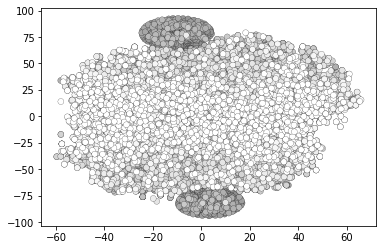

In [119]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, edgecolors='k', linewidth=0.2)

# AE'ing the Ising model

This is a nice challenge for you to implement. You can take the VAE model below, and strip out all of the probabilistic bits.

# VAE'ing the Ising model

Be sure to check out https://arxiv.org/abs/1703.02435

In [50]:
# Gather all the data
# The temperatures that we are going to generate samples at
Ts = np.arange(1.0, 4.0, 0.1)

# For a few different system sizes, store the data in a dictionary with L as key
all_data_for_vae = generate_Ising_configurations(10, 2000, Ts)

Generating samples for L = 10 at T = 1.000
Generating samples for L = 10 at T = 1.100
Generating samples for L = 10 at T = 1.200
Generating samples for L = 10 at T = 1.300
Generating samples for L = 10 at T = 1.400
Generating samples for L = 10 at T = 1.500
Generating samples for L = 10 at T = 1.600
Generating samples for L = 10 at T = 1.700
Generating samples for L = 10 at T = 1.800
Generating samples for L = 10 at T = 1.900
Generating samples for L = 10 at T = 2.000
Generating samples for L = 10 at T = 2.100
Generating samples for L = 10 at T = 2.200
Generating samples for L = 10 at T = 2.300
Generating samples for L = 10 at T = 2.400
Generating samples for L = 10 at T = 2.500
Generating samples for L = 10 at T = 2.600
Generating samples for L = 10 at T = 2.700
Generating samples for L = 10 at T = 2.800
Generating samples for L = 10 at T = 2.900
Generating samples for L = 10 at T = 3.000
Generating samples for L = 10 at T = 3.100
Generating samples for L = 10 at T = 3.200
Generating 

In [85]:
data = []
test_data = []
temperatures = []
Ts = np.arange(1.6, 3.0, 0.1)
for T in Ts:
    for i,snapshot in enumerate(all_data[40]['%.3f'%T]):        
        if i < 900:
            data.append(snapshot)
        else: 
            test_data.append(snapshot)
            temperatures.append(T)
    
data = np.array(data)
test_data = np.array(test_data)
print(data.shape)
print(test_data.shape)

(12600, 1600)
(1400, 1600)


In [86]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import optim
from jax import grad, jit, vmap, value_and_grad
from jax import random

class Encoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256, name='fc1')(x)
        x = nn.relu(x)
        
        # Separate layer for the mean
        mean_x = nn.Dense(self.latent_dim, name='fc2_mean')(x)
        
        # We treat this as the logarithm of the variance, because this can be a small number
        logvar_x = nn.Dense(self.latent_dim, name='fc2_logvar')(x)
        
        return mean_x, logvar_x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(256, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(data.shape[1], name='fc2')(z)
        z = nn.tanh(z)
        return z

In [87]:
class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar
    
    def generate(self, z):
        return self.decoder(z)

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

In [88]:
@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

dim = int(np.sqrt(data.shape[1]))
@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        
        comparison = jnp.concatenate([images[:8].reshape(-1, dim,dim, 1),
                                      recon_images[:8].reshape(-1, dim,dim, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, dim,dim, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, vae)({'params': params})

@jax.jit
def train_step(optimizer, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = vae.apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss, recon_x

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    _, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [89]:
batch_size = 32
init_data = jnp.ones((batch_size, data.shape[1]), jnp.float32)

latent_dim = 1
vae = VAE(latent_dim = latent_dim)
params = vae.init(key, init_data, key)['params']

optimizer = optim.Adam(learning_rate=1e-4).create(params)
optimizer = jax.device_put(optimizer)

rng, z_key, eval_rng = random.split(key, 3)
z = random.normal(z_key, (64, latent_dim))

# Divide into batches
num_batches = len(data) // batch_size

# Loop over the training epochs
num_epochs=200
for epoch in range(num_epochs):

    # Shuffle data
    indices = np.random.permutation(len(data))
    batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

    for b in range(len(batch_indices)):
        batch = jnp.array([data[i] for i in batch_indices[b]])
        rng, key = random.split(rng)
        optimizer = train_step(optimizer, batch, key)
        
    metrics, comparison, sample = eval(optimizer.target, test_data, z, eval_rng)

    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
        epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
    ))

eval epoch: 1, loss: 1038.4983, BCE: 1036.3069, KLD: 2.1914
eval epoch: 2, loss: 879.6173, BCE: 873.7097, KLD: 5.9077
eval epoch: 3, loss: 793.5851, BCE: 782.9792, KLD: 10.6059
eval epoch: 4, loss: 753.8523, BCE: 741.0853, KLD: 12.7670
eval epoch: 5, loss: 734.2978, BCE: 722.1397, KLD: 12.1581
eval epoch: 6, loss: 716.8926, BCE: 705.5199, KLD: 11.3727
eval epoch: 7, loss: 702.5692, BCE: 692.2391, KLD: 10.3301
eval epoch: 8, loss: 692.1684, BCE: 682.7289, KLD: 9.4394
eval epoch: 9, loss: 682.9330, BCE: 674.7103, KLD: 8.2227
eval epoch: 10, loss: 675.3648, BCE: 667.7916, KLD: 7.5732
eval epoch: 11, loss: 666.1878, BCE: 658.9362, KLD: 7.2516
eval epoch: 12, loss: 649.5760, BCE: 642.6871, KLD: 6.8889
eval epoch: 13, loss: 452.6095, BCE: 441.1966, KLD: 11.4129
eval epoch: 14, loss: 441.5727, BCE: 433.3620, KLD: 8.2107
eval epoch: 15, loss: 440.2991, BCE: 431.9697, KLD: 8.3294
eval epoch: 16, loss: 439.5907, BCE: 431.2781, KLD: 8.3125
eval epoch: 17, loss: 439.0298, BCE: 431.0653, KLD: 7.964

Text(0, 0.5, 'Latent variable $\\mu$')

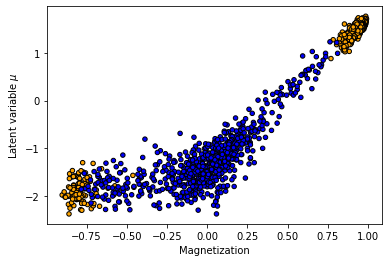

In [110]:
recon_x, mean, logvar = vae.apply({'params': optimizer.target}, test_data, z_key)
magnetization = np.mean(test_data, axis=1)
colors = ['orange' if t < 2.27 else 'blue' for t in temperatures]

fig, ax = plt.subplots()
ax.scatter( magnetization, mean, c=colors, edgecolors='k', s = 20 )
ax.set_xlabel("Magnetization")
ax.set_ylabel("Latent variable $\mu$")

In [108]:
Ts = np.arange(1.6, 3.0, 0.1)

mean_vs_T = []
magnetization_vs_T = []
for T in Ts:
    # Get all samples at this T
    samples_at_T = all_data[40]['%.3f'%T]
    # Get the mean for all of these
    recon_x, mean, logvar = vae.apply({'params': optimizer.target}, samples_at_T, z_key)
    
    mean_vs_T.append( np.mean(mean) )
    magnetization_vs_T.append( np.mean([ np.mean(t) for t in samples_at_T ]) )

Text(0, 0.5, 'Magnetization')

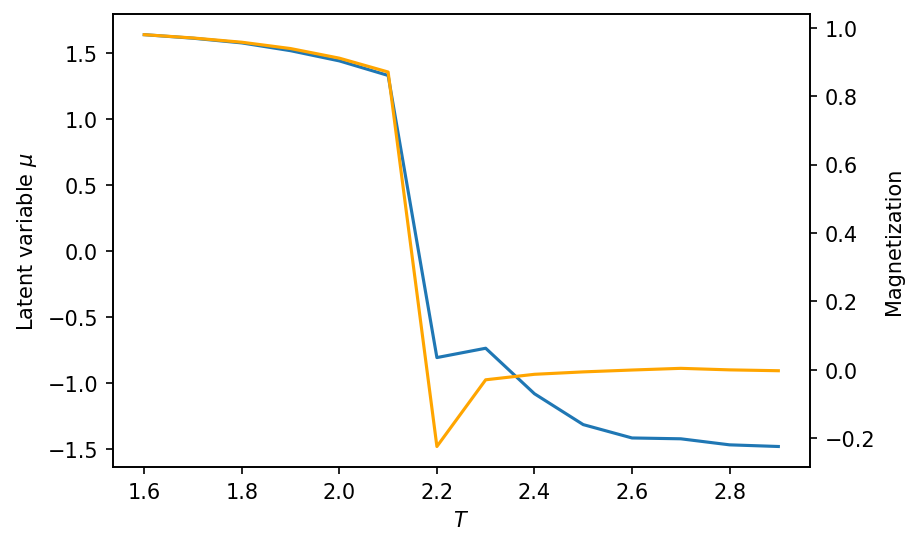

In [109]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ts, mean_vs_T)

ax2 = ax.twinx()
ax2.plot(Ts, magnetization_vs_T, c='orange')

ax.set_xlabel("$T$")
ax.set_ylabel("Latent variable $\mu$")
ax2.set_ylabel("Magnetization")

# Bonus: '2NN'-ing the Ising model

Be sure to check out https://arxiv.org/abs/2006.12953

In [200]:
def compute_distance(d1, d2):
    return np.count_nonzero(d1*d2-1)

In [201]:
def twonn(data):
    N = len(data)
    distance_matrix = np.zeros((N, N))
    
    # Making the distance matrix
    for i in np.arange(len(data)):
        for j in np.arange(i + 1, len(data)):
            distance_matrix[i,j] = compute_distance(data[i], data[j])
    distance_matrix += distance_matrix.transpose()
    
    mu = np.zeros(len(data))
    for i in np.arange(len(data)):
        r1 = 0
        counter = 1
        while r1 == 0:
            r1, r2 = np.sort(distance_matrix[i,:])[counter:counter+2]
            counter += 1
        mu[i] = r2/r1
        
    permutation = np.argsort(mu)
    
    Femp = {}
    for i,p in enumerate(permutation):
        Femp[mu[p]] = i/N
        
    x = np.log(mu)
    y = -np.log(1 - np.array([Femp[m] for m in mu]))
    m = np.linalg.lstsq(x[:,np.newaxis], y, rcond=None)[0][0]
    return m, x, y

In [210]:
IDs = {}
for num_snaps in [100, 250, 500, 1000]:
    print("Num snaps: %d"%num_snaps)
    IDs[num_snaps] = []
    
    for T in Ts:
        print("\t Computing the intrinsic dimension for T = %.2f"%T)
        data = all_data[40]['%.3f'%T]
        snapshots = data[:num_snaps]
        m, _, _ = twonn(snapshots)
        IDs[num_snaps].append(m)

Num snaps: 100
	 Computing the intrinsic dimension for T = 1.60
	 Computing the intrinsic dimension for T = 1.70
	 Computing the intrinsic dimension for T = 1.80
	 Computing the intrinsic dimension for T = 1.90
	 Computing the intrinsic dimension for T = 2.00
	 Computing the intrinsic dimension for T = 2.10
	 Computing the intrinsic dimension for T = 2.20
	 Computing the intrinsic dimension for T = 2.30
	 Computing the intrinsic dimension for T = 2.40
	 Computing the intrinsic dimension for T = 2.50
	 Computing the intrinsic dimension for T = 2.60
	 Computing the intrinsic dimension for T = 2.70
	 Computing the intrinsic dimension for T = 2.80
	 Computing the intrinsic dimension for T = 2.90
Num snaps: 250
	 Computing the intrinsic dimension for T = 1.60
	 Computing the intrinsic dimension for T = 1.70
	 Computing the intrinsic dimension for T = 1.80
	 Computing the intrinsic dimension for T = 1.90
	 Computing the intrinsic dimension for T = 2.00
	 Computing the intrinsic dimension for

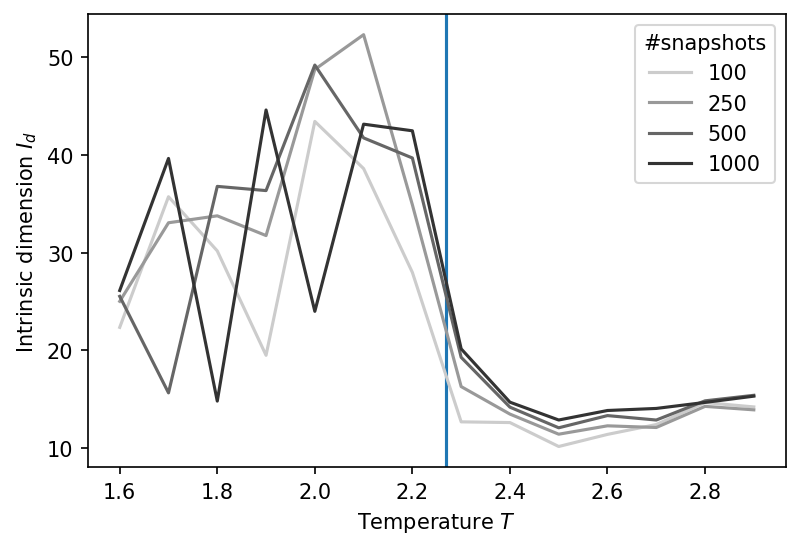

In [211]:
fig, ax = plt.subplots(dpi=150)

Tc = 2/np.log(1+np.sqrt(2))
ax.axvline(x=Tc)

colors = [(0.8, 0.8, 0.8), (0.6, 0.6, 0.6), (0.4, 0.4, 0.4), (0.2, 0.2, 0.2)]
for i,num_snaps in enumerate([100, 250, 500, 1000]):
    ax.plot(Ts, IDs[num_snaps], label="%d"%num_snaps, color=colors[i])
    
ax.set_xlabel("Temperature $T$")
ax.set_ylabel("Intrinsic dimension $I_d$")
ax.legend(fancybox=True, title="#snapshots")

## Challenge ideas

* Use JAX to speed this up!
* Try larger system sizes

## VAE on MNIST for fun!

### MNIST data loader

In [214]:
import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np

_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
    """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA):
        os.makedirs(_DATA)
    out_file = path.join(_DATA, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.)
    test_images = _partial_flatten(test_images) / np.float32(255.)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    if permute_train:
        perm = np.random.RandomState(0).permutation(train_images.shape[0])
        train_images = train_images[perm]
        train_labels = train_labels[perm]

    return train_images, train_labels, test_images, test_labels

In [215]:
train_images, _, test_images, _ = mnist(permute_train=True)

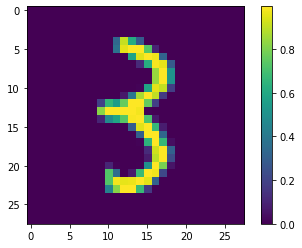

In [239]:
plt.imshow( np.reshape(train_images[0], (28,28)) )
plt.colorbar()

In [264]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import optim
from jax import grad, jit, vmap, value_and_grad
from jax import random

class Encoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128, name='fc1')(x)
        x = nn.relu(x)
        
        # Separate layer for the mean
        mean_x = nn.Dense(self.latent_dim, name='fc2_mean')(x)
        
        # We treat this as the logarithm of the variance, because this can be a small number
        logvar_x = nn.Dense(self.latent_dim, name='fc2_logvar')(x)
        
        return mean_x, logvar_x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(128, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(784, name='fc2')(z)
        z = nn.tanh(z)
        return z
    
class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar
    
    def generate(self, z):
        return self.decoder(z)

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        
        comparison = jnp.concatenate([images[:8].reshape(-1, 28,28, 1),
                                      recon_images[:8].reshape(-1, 28,28, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 28,28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, vae)({'params': params})

@jax.jit
def train_step(optimizer, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = vae.apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss, recon_x

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    _, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [265]:
batch_size = 32
init_data = jnp.ones((batch_size, train_images.shape[1]), jnp.float32)

latent_dim = 10
vae = VAE(latent_dim = latent_dim)
params = vae.init(key, init_data, key)['params']

optimizer = optim.Adam(learning_rate=1e-4).create(params)
optimizer = jax.device_put(optimizer)

rng, z_key, eval_rng = random.split(key, 3)
z = random.normal(z_key, (64, latent_dim))

# Divide into batches
num_batches = len(train_images) // batch_size

# Loop over the training epochs
num_epochs=50
for epoch in range(num_epochs):

    # Shuffle data
    indices = np.random.permutation(len(train_images))
    batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

    for b in range(len(batch_indices)):
        batch = jnp.array([train_images[i] for i in batch_indices[b]])
        rng, key = random.split(rng)
        optimizer = train_step(optimizer, batch, key)
        
    metrics, comparison, sample = eval(optimizer.target, test_images, z, eval_rng)

    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
        epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
    ))

eval epoch: 1, loss: 530.3690, BCE: 529.3066, KLD: 1.0624
eval epoch: 2, loss: 493.4047, BCE: 488.7602, KLD: 4.6445
eval epoch: 3, loss: 451.2292, BCE: 440.3822, KLD: 10.8470
eval epoch: 4, loss: 416.8666, BCE: 402.0394, KLD: 14.8271
eval epoch: 5, loss: 393.2414, BCE: 377.0094, KLD: 16.2319
eval epoch: 6, loss: 377.6202, BCE: 360.8822, KLD: 16.7380
eval epoch: 7, loss: 368.5109, BCE: 352.4630, KLD: 16.0479
eval epoch: 8, loss: 362.9001, BCE: 347.8294, KLD: 15.0708
eval epoch: 9, loss: 358.9094, BCE: 344.8613, KLD: 14.0481
eval epoch: 10, loss: 355.7283, BCE: 342.2442, KLD: 13.4841
eval epoch: 11, loss: 352.9686, BCE: 339.9112, KLD: 13.0574
eval epoch: 12, loss: 350.5136, BCE: 338.0557, KLD: 12.4579
eval epoch: 13, loss: 348.3482, BCE: 336.1229, KLD: 12.2253
eval epoch: 14, loss: 346.3942, BCE: 334.5370, KLD: 11.8572
eval epoch: 15, loss: 344.6098, BCE: 332.8692, KLD: 11.7406
eval epoch: 16, loss: 342.9455, BCE: 331.5701, KLD: 11.3754
eval epoch: 17, loss: 341.4312, BCE: 330.1030, KLD:

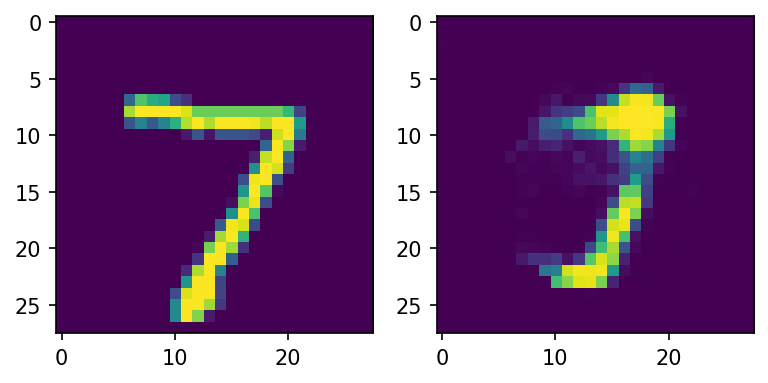

In [268]:
recon_x, mean, logvar = vae.apply({'params': optimizer.target}, test_images, key)

fig, ax = plt.subplots(1,2, dpi=150)
ax[0].imshow(np.reshape(test_images[0], (28,28)))
ax[1].imshow(np.reshape(recon_x[0], (28,28)))

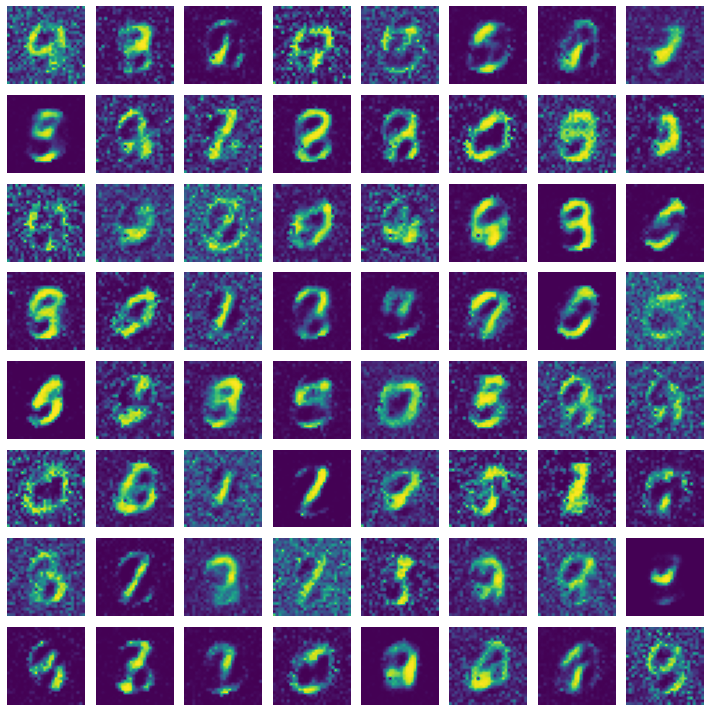

In [267]:
z = random.normal(z_key, (64, latent_dim))
def generate_samples(vae):
    generate_images = vae.generate(z)
    generate_images = generate_images.reshape(-1, 28, 28, 1)
    return generate_images

imgs = nn.apply(generate_samples, vae)({'params': optimizer.target})
fig, ax = plt.subplots(8,8, figsize=(10,10))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(imgs[i*8 + j])
        ax[i,j].axis('off')
fig.tight_layout()